In [60]:
import tensorflow as tf

physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import GridSearchCV

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

from tqdm import tqdm

In [2]:
path = r"/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/images"
# change the working directory to the path where the images are located
os.chdir(path)

# this list holds all the image filename
images = [i for i in os.listdir(path) if i.endswith('.jpg')]

In [3]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224, 224))
    # convert from 'PIL.Image.Image' to numpy array
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1, 224, 224, 3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [4]:
data = {}
pickle_path = r"/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/OpenFoodFacts/features.pkl"

# for image in tqdm(images):
#     feat = extract_features(image, model)
#     data[image] = feat

# Save features dictionary in pickle format
# with open(pickle_path, 'wb') as file:
#     pickle.dump(data, file)

with open(pickle_path, "rb") as input_file:
    data = pickle.load(input_file)

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features
feat = np.array(list(data.values()))

# reshape so that there are 210 samples of 4096 vectors
feat = feat.reshape(-1, 4096)

In [5]:
pickle_reduced_path = r"/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/OpenFoodFacts/reduced_features.pkl"

In [6]:
# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=100, random_state=42)
pca.fit(feat)
x = pca.transform(feat)

data_reduced = {}
for i, image in enumerate(images):
    data_reduced[image] = x[i]

# Save reduced features dictionary in pickle format
# with open(pickle_reduced_path, 'wb') as file:
#     pickle.dump(data_reduced, file)

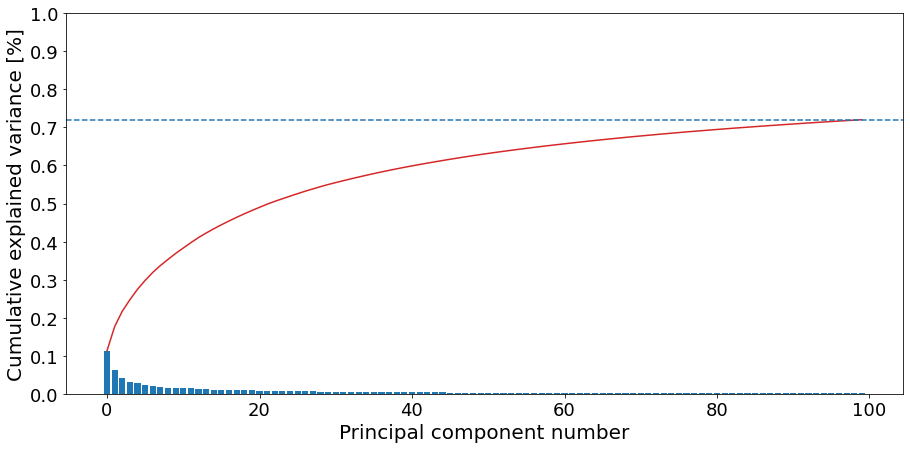

In [7]:
fig, ax = plt.subplots(figsize=(15, 7))
ax.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
ax.plot(pca.explained_variance_ratio_.cumsum(), c='C3')
ax.axhline(y=pca.explained_variance_ratio_.cumsum()[-1], ls='--', c='C0')
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_ylim(0., 1.0)
ax.set_xlabel('Principal component number', fontsize=20)
ax.set_ylabel('Cumulative explained variance [%]', fontsize=20)
ax.tick_params(labelsize=18)

100%|██████████| 1/1 [00:00<00:00,  1.94it/s]
<ipython-input-8-03cf7d65ab41>:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


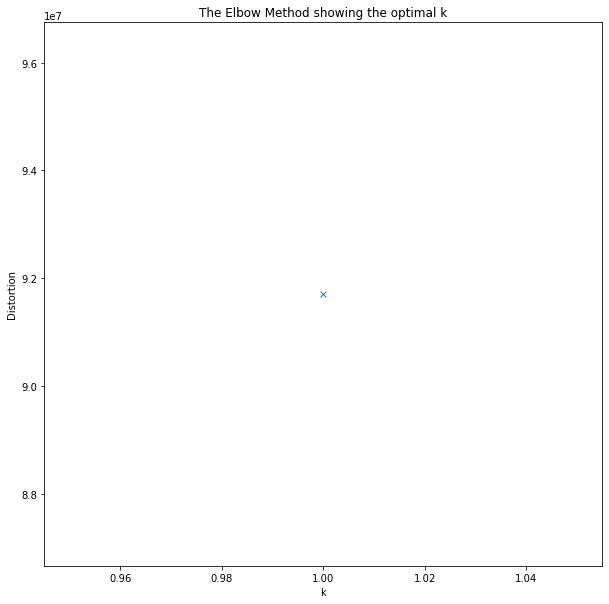

In [8]:
distortions = []
K = range(1, 2)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k, random_state=42)
    kmeanModel.fit(x)
    distortions.append(kmeanModel.inertia_)

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(K, distortions, 'x-')
ax.set_xlabel('k')
ax.set_ylabel('Distortion')
ax.set_title('The Elbow Method showing the optimal k')
fig.show()

In [9]:
n_clusters = 8

# cluster feature vectors
kmeans = KMeans(n_clusters=n_clusters, random_state=22)
kmeans.fit(x)

# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames, kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [10]:
# function that lets you view a cluster (based on identifier)        
def view_cluster(groups, cluster, nb_im):
    plt.figure(figsize = (25, 25))
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > nb_im:
        print(f"Clipping cluster size from {len(files)} to {nb_im}")
        files = files[:nb_im-1]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10, 10, index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [11]:

   
# # this is just incase you want to see which value for k might be the best 
# sse = []
# list_k = list(range(3, 50))

# for k in list_k:
#     km = KMeans(n_clusters=k, random_state=22, n_jobs=-1)
#     km.fit(x)
    
#     sse.append(km.inertia_)

# # Plot sse against k
# plt.figure(figsize=(6, 6))
# plt.plot(list_k, sse)
# plt.xlabel(r'Number of clusters *k*')
# plt.ylabel('Sum of squared distance');

In [12]:
for cluster in groups:
    print(cluster, len(groups[cluster]))

5 6103
6 2297
1 6606
7 3343
2 3147
3 5401
0 4186
4 1877


5
Clipping cluster size from 6103 to 10
6
Clipping cluster size from 2297 to 10
1
Clipping cluster size from 6606 to 10
7
Clipping cluster size from 3343 to 10
2
Clipping cluster size from 3147 to 10
3
Clipping cluster size from 5401 to 10
0
Clipping cluster size from 4186 to 10
4
Clipping cluster size from 1877 to 10


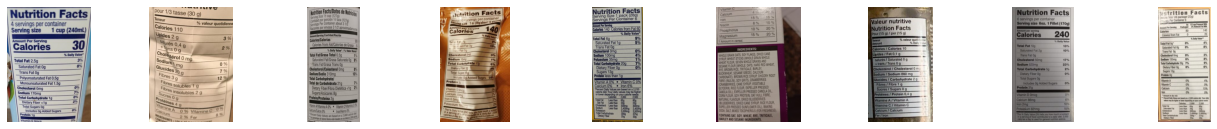

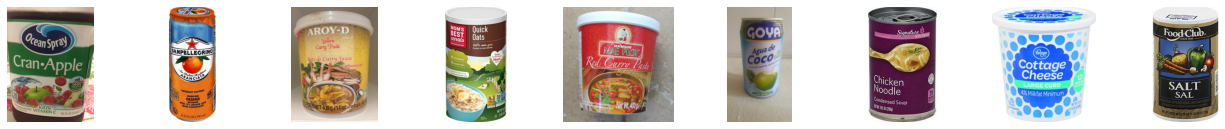

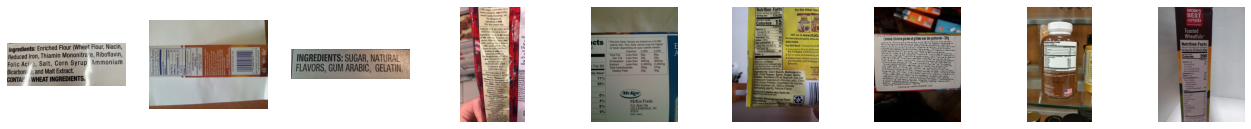

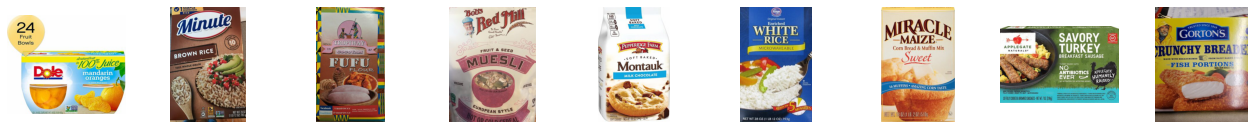

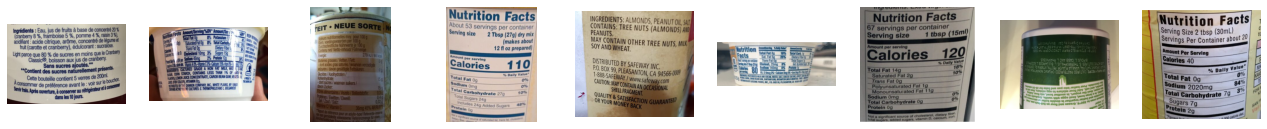

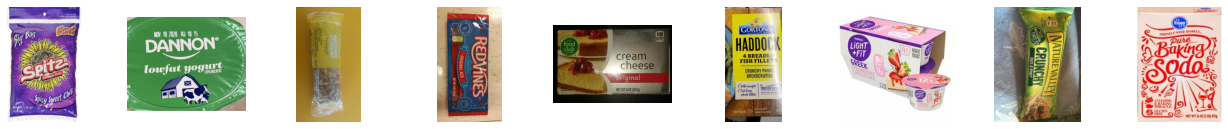

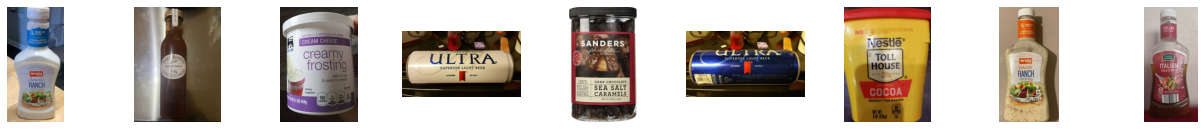

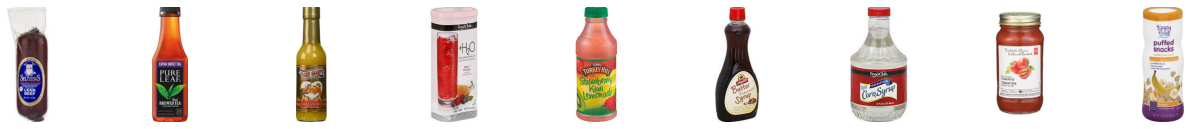

In [13]:
for cluster in groups:
    print(cluster)
    view_cluster(groups, cluster, 10)

In [14]:
# with open('/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/OpenFoodFacts/labels_list.txt', 'w') as file:
#     for label in groups[5]+groups[1]+groups[2]:
#         file.write(label+'\n')

## JSON with products names

In [15]:
import json

json_path = r"/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/OpenFoodFacts/label_of_products.json"

with open(json_path, 'r') as label_file:
    labels = json.load(label_file)

In [16]:
labels['0041570054130']

{'product_name': 'Almond breeze', 'abbreviated_product_name': 'NA'}

In [17]:
for key in labels:
    if key.count('0')==len(key):
        print(key)

0000000000
0000000000000
000
0000


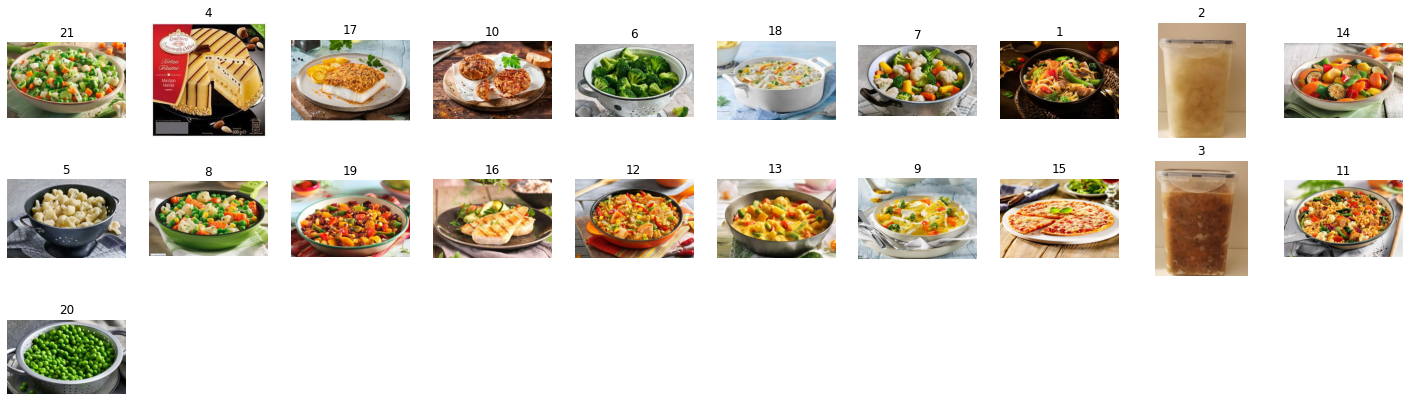

In [18]:
#key = '0041331124669'
key = '0000000000'

index = 0
plt.figure(figsize = (25, 25))
for file in images:
    if file.split('_')[0]==key:
        plt.subplot(10, 10, index+1)
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        plt.title(file.split('_')[1].split('.')[0])
        index += 1

In [19]:
for g in groups:
    for im in groups[g]:
        if im.split('_')[0]==key:
            print(f"{g}: {im}")

7: 0000000000_4.400.jpg
0: 0000000000_21.400.jpg
0: 0000000000_17.400.jpg
0: 0000000000_10.400.jpg
0: 0000000000_6.400.jpg
0: 0000000000_18.400.jpg
0: 0000000000_7.400.jpg
0: 0000000000_1.400.jpg
0: 0000000000_2.400.jpg
0: 0000000000_14.400.jpg
0: 0000000000_5.400.jpg
0: 0000000000_8.400.jpg
0: 0000000000_19.400.jpg
0: 0000000000_16.400.jpg
0: 0000000000_12.400.jpg
0: 0000000000_13.400.jpg
0: 0000000000_9.400.jpg
0: 0000000000_15.400.jpg
0: 0000000000_3.400.jpg
0: 0000000000_11.400.jpg
0: 0000000000_20.400.jpg


## Different clustering with DBSCAN

In [20]:
neigh = NearestNeighbors(n_neighbors=10, n_jobs=-1)
nbrs = neigh.fit(x)
distances, indices = nbrs.kneighbors(x)

In [21]:
distances.shape, indices.shape

((32960, 10), (32960, 10))

In [22]:
indices

array([[    0,  5349, 15471, ..., 18073, 12728,  9372],
       [    1, 31936, 12742, ...,  1480, 17718, 17708],
       [    2, 27455, 28894, ..., 29390,  8929,   425],
       ...,
       [32957, 18697,  5595, ...,  3314,  3651, 29282],
       [32958,  7134,  7590, ..., 17053, 19035, 31439],
       [32959, 30851, 10318, ...,    77, 17871, 29705]])

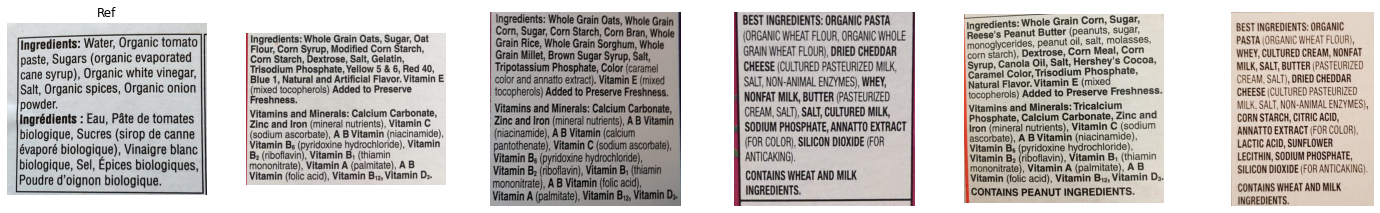

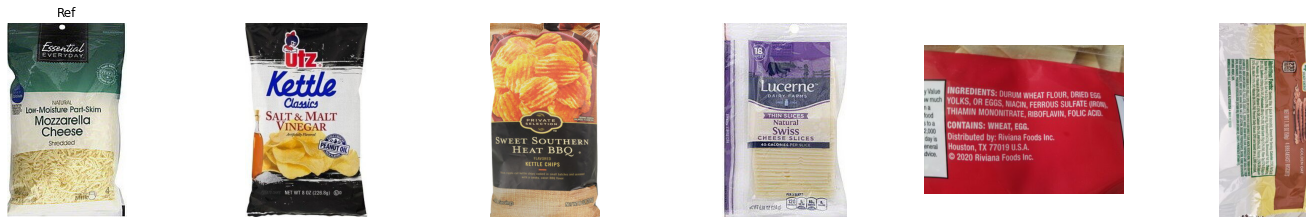

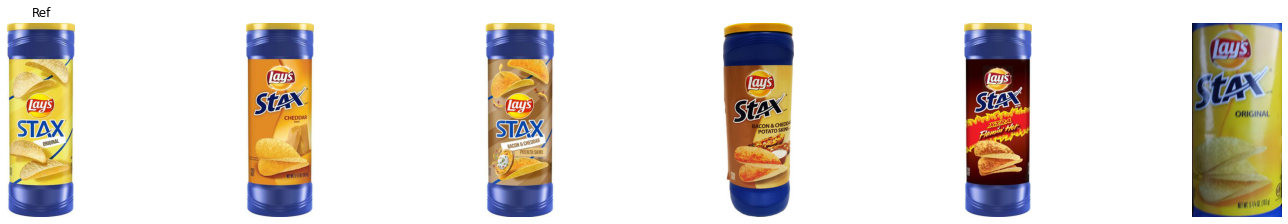

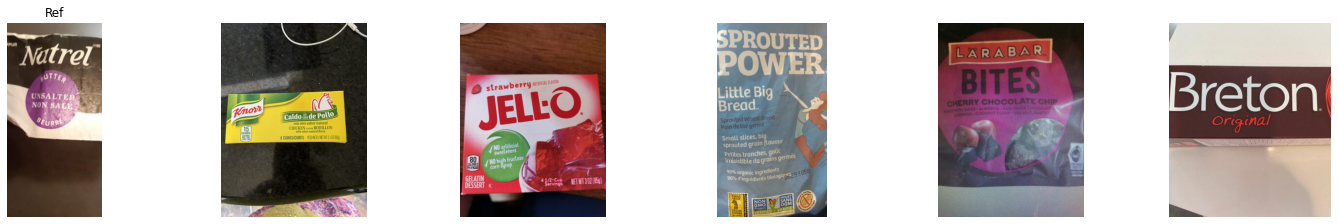

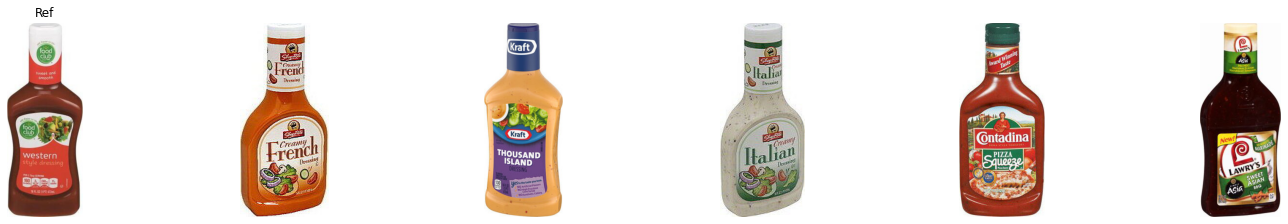

In [23]:
#key = '0041331124669'
nb_neighbours = 5

for key in np.random.choice(range(len(images)), size=5, replace=False):
    index = 0
    fig = plt.figure(figsize=(25, 25))
    im_neighbours = [images[key]] + [images[i] for i in indices[key][1:nb_neighbours+1]]
    for im in im_neighbours:
        plt.subplot(6, 6, index+1)
        img = load_img(im)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')
        if index==0:
            plt.title('Ref')
        index += 1

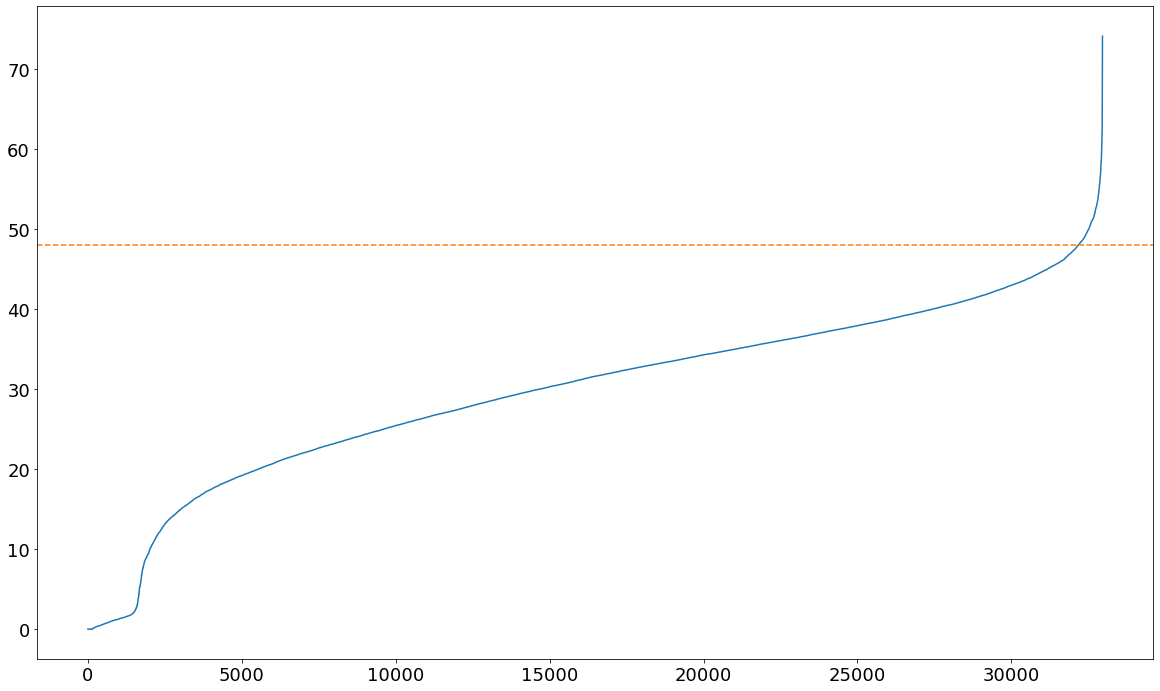

In [24]:
distances_sorted = np.sort(distances, axis=0)
distances_sorted = distances_sorted[:,1]
fig, ax = plt.subplots(figsize=(20, 12))
ax.plot(distances_sorted)
ax.axhline(y=48, ls='--', c='C1')
ax.tick_params(labelsize=18)
# ax.set_xlim(0, 2500)
# ax.set_ylim(0, 5)

In [25]:
# dbscan = DBSCAN(eps=48, min_samples=100)
# dbscan.fit(x)

# # holds the cluster id and the images { id: [images] }
# groups = {}
# for file, cluster in zip(filenames, dbscan.labels_):
#     if cluster not in groups.keys():
#         groups[cluster] = []
#         groups[cluster].append(file)
#     else:
#         groups[cluster].append(file)

In [26]:
# for cluster in groups:
#     print(cluster, len(groups[cluster]))

In [27]:
# for cluster in groups:
#     view_cluster(cluster)

In [28]:
# fig, ax = plt.subplots(figsize=(20, 12))
# ax.scatter(x[:, 0], x[:, 2], alpha=0.3)
# ax.tick_params(labelsize=18)
# ax.set_xlabel('PC1', fontsize=20)
# ax.set_ylabel('PC2', fontsize=20)


## Prédiction nouveau produit

In [29]:
x.shape

(32960, 100)

### Random Forest

In [58]:
X_train, X_test, y_train, y_test = train_test_split(x, kmeans.labels_, test_size=0.1, random_state=42)
rf = RandomForestClassifier(n_estimators=10, max_depth=None, min_samples_split=2, random_state=0, verbose=0, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=0)

In [59]:
y_pred = rf.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):>27}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred)}")

Accuracy:          0.8825849514563107
Balanced accuracy: 0.8675691846965662


### SVC

In [69]:
parameters = {'kernel':('linear', 'poly'), 'C':[0.1, 1, 10, 100], 'degree':[2, 3, 4]}
svc = SVC()
clf = GridSearchCV(svc, parameters, verbose=2, n_jobs=-1)
clf.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'degree': [2, 3, 4],
                         'kernel': ('linear', 'poly')},
             verbose=2)

In [70]:
pd.DataFrame(clf.cv_results_)

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       11.485014      1.054573         1.360737        0.093801     0.1   
1       97.571441      2.352252        19.502588        1.213517     0.1   
2       11.267319      0.772037         1.263102        0.047326     0.1   
3      131.834805      4.369070        21.067413        0.981013     0.1   
4       11.620513      1.676666         1.293024        0.171690     0.1   
5      204.876347      8.429751        25.030155        0.884559     0.1   
6       10.817228      0.289464         1.273758        0.113851       1   
7       46.472861      3.640662        11.323345        1.380444       1   
8       11.386473      0.690532         1.276428        0.099230       1   
9       58.900264      2.193400        12.734124        0.696168       1   
10      12.451784      1.031216         1.348697        0.142306       1   
11     116.547492      7.070390        17.316655        1.039295       1   
12      11.425034      1.655416         1.317301        0.099525      10   
13      33.878820      2.040673         8.320156        0.113926      10   
14      11.310069      1.060055         1.294088        0.190103      10   
15      43.236005      1.869488        10.044860        1.073433      10   
16      11.641702      0.962803         1.236240        0.088286      10   
17      93.193085      4.186636        13.732374        0.963437      10   
18      10.978285      0.672666         1.275010        0.154942     100   
19      32.817353      2.009355         7.903809        0.562411     100   
20      11.573251      0.467016         1.321119        0.107589     100   
21      43.786690      1.742788        10.557105        0.966891     100   
22      11.926452      0.724798         1.529335        0.223854     100   
23      63.441916      5.456300         8.986901        0.497730     100   

   param_degree param_kernel                                       params  \
0             2       linear  {'C': 0.1, 'degree': 2, 'kernel': 'linear'}   
1             2         poly    {'C': 0.1, 'degree': 2, 'kernel': 'poly'}   
2             3       linear  {'C': 0.1, 'degree': 3, 'kernel': 'linear'}   
3             3         poly    {'C': 0.1, 'degree': 3, 'kernel': 'poly'}   
4             4       linear  {'C': 0.1, 'degree': 4, 'kernel': 'linear'}   
5             4         poly    {'C': 0.1, 'degree': 4, 'kernel': 'poly'}   
6             2       linear    {'C': 1, 'degree': 2, 'kernel': 'linear'}   
7             2         poly      {'C': 1, 'degree': 2, 'kernel': 'poly'}   
8             3       linear    {'C': 1, 'degree': 3, 'kernel': 'linear'}   
9             3         poly      {'C': 1, 'degree': 3, 'kernel': 'poly'}   
10            4       linear    {'C': 1, 'degree': 4, 'kernel': 'linear'}   
11            4         poly      {'C': 1, 'degree': 4, 'kernel': 'poly'}   
12            2       linear   {'C': 10, 'degree': 2, 'kernel': 'linear'}   
13            2         poly     {'C': 10, 'degree': 2, 'kernel': 'poly'}   
14            3       linear   {'C': 10, 'degree': 3, 'kernel': 'linear'}   
15            3         poly     {'C': 10, 'degree': 3, 'kernel': 'poly'}   
16            4       linear   {'C': 10, 'degree': 4, 'kernel': 'linear'}   
17            4         poly     {'C': 10, 'degree': 4, 'kernel': 'poly'}   
18            2       linear  {'C': 100, 'degree': 2, 'kernel': 'linear'}   
19            2         poly    {'C': 100, 'degree': 2, 'kernel': 'poly'}   
20            3       linear  {'C': 100, 'degree': 3, 'kernel': 'linear'}   
21            3         poly    {'C': 100, 'degree': 3, 'kernel': 'poly'}   
22            4       linear  {'C': 100, 'degree': 4, 'kernel': 'linear'}   
23            4         poly    {'C': 100, 'degree': 4, 'kernel': 'poly'}   

    split0_test_score  split1_test_score  split2_test_score  \
0            0.978931           0.977414           0.976909   
1            0.943705           0.936120           

In [66]:
svm = SVC(kernel='linear', C=0.1)

svm.fit(X_train, y_train)

SVC(C=0.1, kernel='linear')

In [68]:
y_pred_svm = svm.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):>27}")
print(f"Balanced accuracy: {balanced_accuracy_score(y_test, y_pred_svm)}")

Accuracy:          0.9830097087378641
Balanced accuracy: 0.979133307042749


In [95]:
new_image = '/home/kevin.bouchaud@Digital-Grenoble.local/code/Data_For_Good/pringles-original-175g.jpg'
new_feat = extract_features(new_image, model)

In [96]:
new_x = pca.transform(new_feat)
svm.predict(new_x)

array([6], dtype=int32)

Clipping cluster size from 2297 to 40


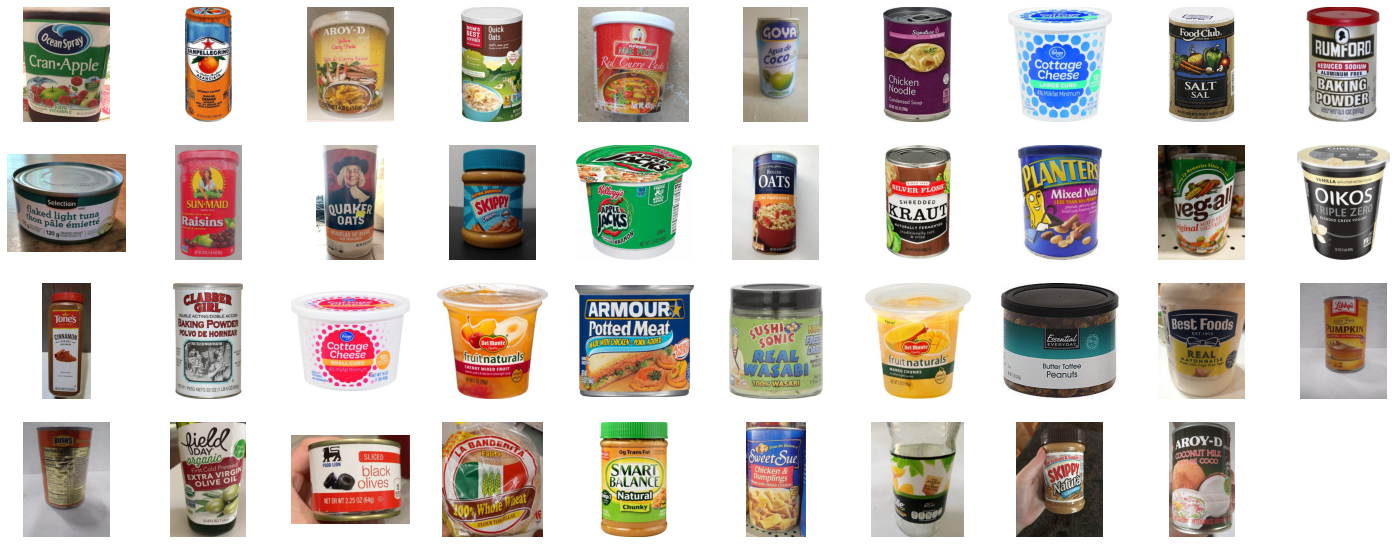

In [98]:
view_cluster(groups, 6, 40)